In [1]:
from datasets import Dataset
from gpn.data import GenomeMSA
from gpn.msa.inference import run_inference
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score
from scipy.spatial.distance import cdist
from scipy.stats import zscore
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SPLITS = [
    [str(i) for i in range(1, 23) if i % 2 == 1] + ["X"],
    [str(i) for i in range(1, 23) if i % 2 == 0] + ["Y"],
]
D = 768
features = [f"embedding_{i}" for i in range(D)]
SPLITS

[['1', '3', '5', '7', '9', '11', '13', '15', '17', '19', '21', 'X'],
 ['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', 'Y']]

In [3]:
cols = ["chrom", "pos", "ref", "alt"]


def match_columns(df, target, covariates):
    pos = df[df[target]]
    neg = df[~df[target]]
    D = cdist(pos[covariates], neg[covariates])

    closest = []
    dists = []
    for i in tqdm(range(len(pos))):
        D[i, neg.chrom != pos.iloc[i].chrom] = np.inf  # ensure picking from same chrom
        j = np.argmin(D[i])
        closest.append(j)
        D[:, j] = np.inf  # ensure it cannot be picked up again
    return pd.concat([pos, neg.iloc[closest]])

In [4]:
ldscore = pd.read_parquet("../../results/tmp/ldscore.processed.parquet")
ldscore

,chrom,pos,ref,alt,AF,ld_score
0,1,11063,T,G,0.000048,5.738593
1,1,13259,G,A,0.000278,5.048821
2,1,17641,G,A,0.000831,1.683291
3,1,57222,T,C,0.000659,2.475932
4,1,58396,T,C,0.00024,29.534102
...,...,...,...,...,...,...
22153592,X,155697134,G,A,0.000028,28.358136
22153593,X,155697920,G,A,0.302726,406.085388
22153594,X,155699751,C,T,0.245915,483.126375
22153595,X,155700569,A,G,0.246325,484.684299


In [5]:
ldscore["MAF"] = ldscore['AF'].apply(lambda x: min(x, 1-x))

In [6]:
pips = pd.read_parquet("../../results/tmp/my_pips.parquet")
pips

,chrom,pos,ref,alt,trait,method,pip,region,maf,LD_HWE,LD_SV
0,1,820055,T,G,IGF1,SUSIE,0.001039,chr1:708908-3708908,0.005550,False,False
1,1,832873,A,C,IGF1,SUSIE,0.003492,chr1:708908-3708908,0.236748,False,False
2,1,833068,G,A,CRP,SUSIE,0.004263,chr1:64194-3064194,0.106004,False,False
3,1,834583,G,A,CRP,SUSIE,0.004209,chr1:64194-3064194,0.105298,False,False
4,1,835506,G,A,CRP,SUSIE,0.004478,chr1:64194-3064194,0.104339,False,False
...,...,...,...,...,...,...,...,...,...,...,...
4763178,22,50783624,G,A,Mono,SUSIE,0.001769,chr22:48513402-51304566,0.300835,False,False
4763179,22,50784537,G,A,Mono,SUSIE,0.001520,chr22:48513402-51304566,0.304649,False,False
4763180,22,50790482,G,A,Mono,SUSIE,0.003555,chr22:48513402-51304566,0.299990,False,False
4763181,22,50791289,A,T,Mono,SUSIE,0.003565,chr22:48513402-51304566,0.296184,False,False


In [7]:
pips = pips[(~pips.LD_HWE) & (~pips.LD_SV)]
pips

,chrom,pos,ref,alt,trait,method,pip,region,maf,LD_HWE,LD_SV
0,1,820055,T,G,IGF1,SUSIE,0.001039,chr1:708908-3708908,0.005550,False,False
1,1,832873,A,C,IGF1,SUSIE,0.003492,chr1:708908-3708908,0.236748,False,False
2,1,833068,G,A,CRP,SUSIE,0.004263,chr1:64194-3064194,0.106004,False,False
3,1,834583,G,A,CRP,SUSIE,0.004209,chr1:64194-3064194,0.105298,False,False
4,1,835506,G,A,CRP,SUSIE,0.004478,chr1:64194-3064194,0.104339,False,False
...,...,...,...,...,...,...,...,...,...,...,...
4763178,22,50783624,G,A,Mono,SUSIE,0.001769,chr22:48513402-51304566,0.300835,False,False
4763179,22,50784537,G,A,Mono,SUSIE,0.001520,chr22:48513402-51304566,0.304649,False,False
4763180,22,50790482,G,A,Mono,SUSIE,0.003555,chr22:48513402-51304566,0.299990,False,False
4763181,22,50791289,A,T,Mono,SUSIE,0.003565,chr22:48513402-51304566,0.296184,False,False


In [8]:
# option 1
pips = pips[pips.method=="SUSIE"]

# option 2
#pips = pips.groupby(["chrom", "pos", "ref", "alt", "trait"]).agg({"method": "nunique", "pip": "mean", "maf": "mean"}).reset_index()
#pips = pips[pips.method==2]

pips

,chrom,pos,ref,alt,trait,method,pip,region,maf,LD_HWE,LD_SV
0,1,820055,T,G,IGF1,SUSIE,0.001039,chr1:708908-3708908,0.005550,False,False
1,1,832873,A,C,IGF1,SUSIE,0.003492,chr1:708908-3708908,0.236748,False,False
2,1,833068,G,A,CRP,SUSIE,0.004263,chr1:64194-3064194,0.106004,False,False
3,1,834583,G,A,CRP,SUSIE,0.004209,chr1:64194-3064194,0.105298,False,False
4,1,835506,G,A,CRP,SUSIE,0.004478,chr1:64194-3064194,0.104339,False,False
...,...,...,...,...,...,...,...,...,...,...,...
4763178,22,50783624,G,A,Mono,SUSIE,0.001769,chr22:48513402-51304566,0.300835,False,False
4763179,22,50784537,G,A,Mono,SUSIE,0.001520,chr22:48513402-51304566,0.304649,False,False
4763180,22,50790482,G,A,Mono,SUSIE,0.003555,chr22:48513402-51304566,0.299990,False,False
4763181,22,50791289,A,T,Mono,SUSIE,0.003565,chr22:48513402-51304566,0.296184,False,False


In [9]:
# option 1
#pips_agg = pips.groupby(cols).agg({"pip": "sum", "maf": "mean", "trait": "count"}).reset_index().rename(columns={"trait": "n_traits"})
#pips_agg["pip"] = pips_agg.pip / len(pips.trait.unique())  # average pip

# option 2
pips_agg = pips.groupby(cols).agg({"pip": "max", "maf": "mean"}).reset_index()

pips_agg

,chrom,pos,ref,alt,pip,maf
0,1,820055,T,G,0.001039,0.005550
1,1,832873,A,C,0.003492,0.236748
2,1,833068,G,A,0.004263,0.106004
3,1,834583,G,A,0.004209,0.105298
4,1,835506,G,A,0.004478,0.104339
...,...,...,...,...,...,...
1632740,9,138172038,C,T,0.001342,0.372683
1632741,9,138173218,G,A,0.045044,0.165755
1632742,9,138174172,T,C,0.001422,0.372984
1632743,9,138174508,T,C,0.001392,0.399574


In [10]:
models = [
    "CADD.RawScore",
    "phyloP",
    "phastCons",
    "phyloP-Zoonomia",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
]
embedding_model = models[-1]


model_renaming = {
    "CADD.RawScore": "CADD",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA",
    "phyloP": "phyloP-100-vertebrates",
    "phastCons": "phastCons-100-vertebrates",
    "phyloP-Zoonomia": "phyloP-241-mammals",
}

V = pd.read_parquet("../../results/finemapping/processed/test.parquet")
d = Path(f"../../results/preds/results/finemapping/processed")
for m in models:
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V[model_name] = pd.read_parquet(model_path)["score"].values
models = [model_renaming.get(m, m) for m in models]
V

,chrom,pos,ref,alt,CADD,phyloP-100-vertebrates,phastCons-100-vertebrates,phyloP-241-mammals,GPN-MSA
0,1,832873,A,C,0.145778,0.677,-0.001,3.457,0.546393
1,1,833068,G,A,0.016390,-0.036,-0.002,0.411,1.718937
2,1,834583,G,A,0.051453,0.479,-0.186,0.410,0.066588
3,1,835506,G,A,0.177210,0.645,-0.000,3.043,-0.150484
4,1,841852,C,T,0.025537,0.459,-0.000,-0.317,-0.040198
...,...,...,...,...,...,...,...,...,...
1821943,22,50783624,G,A,-0.438139,0.932,-0.000,0.738,-0.719305
1821944,22,50784537,G,A,-0.645151,-0.249,-0.357,-0.471,0.157599
1821945,22,50790482,G,A,0.020462,-0.349,-0.002,0.071,0.066454
1821946,22,50791289,A,T,-0.261473,-0.062,-0.058,0.335,-0.829577


In [11]:
V = pd.concat([
    V,
    pd.read_parquet(f"../../results/preds/vep_embedding/results/finemapping/processed/{embedding_model}.parquet")
], axis=1)
V

,chrom,pos,ref,alt,CADD,phyloP-100-vertebrates,phastCons-100-vertebrates,phyloP-241-mammals,GPN-MSA,embedding_0,...,embedding_758,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767
0,1,832873,A,C,0.145778,0.677,-0.001,3.457,0.546393,327.407166,...,118.821938,476.082916,47.642521,243.169952,83.901390,106.842987,136.855988,267.079407,190.964325,57.205971
1,1,833068,G,A,0.016390,-0.036,-0.002,0.411,1.718937,147.760559,...,81.839973,298.484619,29.851658,157.940964,64.164658,51.969040,37.594158,250.187012,81.586136,78.551956
2,1,834583,G,A,0.051453,0.479,-0.186,0.410,0.066588,138.471649,...,175.601807,160.399094,47.566139,124.103378,55.504795,83.486725,116.397141,133.027679,98.886223,68.059204
3,1,835506,G,A,0.177210,0.645,-0.000,3.043,-0.150484,119.532608,...,139.702240,292.348816,60.947781,120.855606,31.584688,57.365559,38.881702,149.588074,30.385689,96.709305
4,1,841852,C,T,0.025537,0.459,-0.000,-0.317,-0.040198,236.072586,...,139.943115,330.970093,31.695229,142.334061,34.199543,43.387611,52.077309,140.667084,35.862450,67.422905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821943,22,50783624,G,A,-0.438139,0.932,-0.000,0.738,-0.719305,88.744247,...,137.403030,222.140106,49.977669,77.113968,35.358963,59.509201,118.620300,78.555145,54.243546,112.973755
1821944,22,50784537,G,A,-0.645151,-0.249,-0.357,-0.471,0.157599,303.820862,...,122.213409,515.731323,58.894569,212.943604,86.336014,111.217133,217.519592,256.985840,251.811249,83.490044
1821945,22,50790482,G,A,0.020462,-0.349,-0.002,0.071,0.066454,271.307465,...,130.699799,495.617188,44.539875,209.166031,85.865372,95.644203,232.313690,241.816727,246.717041,92.467789
1821946,22,50791289,A,T,-0.261473,-0.062,-0.058,0.335,-0.829577,215.936768,...,225.337997,308.721039,45.186890,135.191132,101.618546,105.227776,160.207275,173.959747,251.927643,78.020370


In [12]:
V = V.merge(ldscore, on=cols, how="inner")
V

,chrom,pos,ref,alt,CADD,phyloP-100-vertebrates,phastCons-100-vertebrates,phyloP-241-mammals,GPN-MSA,embedding_0,...,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767,AF,ld_score,MAF
0,1,832873,A,C,0.145778,0.677,-0.001,3.457,0.546393,327.407166,...,243.169952,83.901390,106.842987,136.855988,267.079407,190.964325,57.205971,0.763689,65.233773,0.236311
1,1,833068,G,A,0.016390,-0.036,-0.002,0.411,1.718937,147.760559,...,157.940964,64.164658,51.969040,37.594158,250.187012,81.586136,78.551956,0.105508,39.035791,0.105508
2,1,834583,G,A,0.051453,0.479,-0.186,0.410,0.066588,138.471649,...,124.103378,55.504795,83.486725,116.397141,133.027679,98.886223,68.059204,0.104803,39.16434,0.104803
3,1,835506,G,A,0.177210,0.645,-0.000,3.043,-0.150484,119.532608,...,120.855606,31.584688,57.365559,38.881702,149.588074,30.385689,96.709305,0.103867,38.977357,0.103867
4,1,841852,C,T,0.025537,0.459,-0.000,-0.317,-0.040198,236.072586,...,142.334061,34.199543,43.387611,52.077309,140.667084,35.862450,67.422905,0.095105,39.579469,0.095105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1816798,22,50783624,G,A,-0.438139,0.932,-0.000,0.738,-0.719305,88.744247,...,77.113968,35.358963,59.509201,118.620300,78.555145,54.243546,112.973755,0.299913,38.986375,0.299913
1816799,22,50784537,G,A,-0.645151,-0.249,-0.357,-0.471,0.157599,303.820862,...,212.943604,86.336014,111.217133,217.519592,256.985840,251.811249,83.490044,0.30374,39.121952,0.303740
1816800,22,50790482,G,A,0.020462,-0.349,-0.002,0.071,0.066454,271.307465,...,209.166031,85.865372,95.644203,232.313690,241.816727,246.717041,92.467789,0.299102,37.73791,0.299102
1816801,22,50791289,A,T,-0.261473,-0.062,-0.058,0.335,-0.829577,215.936768,...,135.191132,101.618546,105.227776,160.207275,173.959747,251.927643,78.020370,0.295325,37.576431,0.295325


In [13]:
exclude_abs = ["CADD", "phyloP", "phyloP-100-vertebrates", "phyloP-241-mammals", "phyloP-Zoonomia", 'phastCons-100-vertebrates']
for m in models:
    if m in V.columns and m not in exclude_abs:
        print(m)
        V[m] = -V[m].abs()

GPN-MSA


In [14]:
not_na = ~V[models].isna().any(axis=1)
not_na.mean()

0.9878308215034872

In [15]:
V = V[not_na]
V.shape

(1794694, 780)

In [16]:
V2 = V.merge(pips_agg, how="inner", on=cols).sort_values("pip", ascending=False)
V2["maf_z"] = zscore(V2["maf"])
V2["ld_score_z"] = zscore(V2["ld_score"].astype(float))

V2.loc[V2.pip > 0.9, "Likely causal"] = True  # 0.99?
V2.loc[V2.pip < 0.01, "Likely causal"] = False

V2 = V2.dropna(subset="Likely causal")
V2["Likely causal"] = V2["Likely causal"].astype(bool)
V2["Likely causal"].value_counts()

Likely causal
False    1246842
True        2284
Name: count, dtype: int64

In [17]:
V2 = match_columns(
    V2, "Likely causal",
    [
        "maf_z",
        "ld_score_z"
    ]
)
V2 = V2.drop_duplicates()
V2["Likely causal"].value_counts()

100%|██████████| 2284/2284 [03:15<00:00, 11.70it/s]


Likely causal
True     2284
False    2284
Name: count, dtype: int64

In [18]:
enformer = pd.read_parquet("../../results/enformer/merged.correct_ref_alt.parquet")
enformer

,chrom,pos,ref,alt,Enformer_l1,Enformer_l2,Enformer_linf,ref_nuc
0,1,10642,G,A,-4.500000,-0.130371,-0.044769,G
1,1,11008,C,G,-3.861328,-0.087769,-0.032928,C
2,1,11012,C,G,-12.265625,-0.251465,-0.085571,C
3,1,11063,T,G,-6.304688,-0.156494,-0.029846,T
4,1,13110,G,A,-1.482422,-0.043243,-0.009705,G
...,...,...,...,...,...,...,...,...
25273048,22,50802392,C,T,-0.846680,-0.020538,-0.006084,C
25273049,22,50802857,T,G,-2.433594,-0.051331,-0.017822,T
25273050,22,50802958,C,G,-3.312500,-0.091431,-0.012917,C
25273051,22,50805735,A,G,-2.132812,-0.042755,-0.004509,A


In [19]:
V2 = V2.merge(enformer, on=cols, how="inner")
models += [
    "Enformer_l2",
    #"Enformer_l1",
    #"Enformer_linf",
]
V2

,chrom,pos,ref,alt,CADD,phyloP-100-vertebrates,phastCons-100-vertebrates,phyloP-241-mammals,GPN-MSA,embedding_0,...,MAF,pip,maf,maf_z,ld_score_z,Likely causal,Enformer_l1,Enformer_l2,Enformer_linf,ref_nuc
0,7,92779056,C,T,-0.505089,0.684,-0.309,1.046,-1.343505,56.629822,...,0.094373,1.000000,0.093829,-0.706003,-0.769044,True,-16.875000,-0.546875,-0.218140,C
1,16,360178,G,A,-0.001349,0.325,-0.000,0.354,-0.888208,104.406738,...,0.047924,1.000000,0.047926,-0.999749,-0.784941,True,-1.456055,-0.045898,-0.014061,G
2,15,100152748,G,A,-2.675768,-1.509,-0.973,-7.034,-5.089054,80.948273,...,0.112873,1.000000,0.113125,-0.582524,-0.934552,True,-10.062500,-0.267578,-0.062073,G
3,15,101178034,C,G,-2.212074,-4.878,-1.000,-8.903,-9.922956,129.430801,...,0.056663,1.000000,0.056641,-0.943977,-0.863351,True,-7.867188,-0.263916,-0.049225,C
4,16,99541,G,A,-0.216803,-0.505,-0.134,-0.123,-1.849506,202.942780,...,0.002177,1.000000,0.002140,-1.292745,-1.013055,True,-0.733887,-0.020676,-0.002865,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4106,20,44674601,C,T,0.067094,-0.157,-0.018,-0.134,-0.584491,316.360657,...,0.440098,0.004999,0.439795,1.507918,-0.621893,False,-1.317383,-0.033447,-0.008301,C
4107,14,49573107,A,G,-0.116551,-0.891,-0.038,-0.075,-3.010699,68.286903,...,0.471034,0.003950,0.471722,1.712222,0.362529,False,-4.089844,-0.089478,-0.010010,A
4108,10,124564186,C,T,0.104688,0.970,-0.001,0.656,-1.258399,303.780731,...,0.199862,0.004669,0.199716,-0.028409,-0.342782,False,-1.516602,-0.048706,-0.013840,C
4109,19,33856402,T,G,-0.122923,0.369,-0.009,0.183,-1.561101,275.394409,...,0.223208,0.001881,0.223441,0.123413,-0.713268,False,-0.962402,-0.022781,-0.003344,T


In [20]:
V = V2
V["label"] = V["Likely causal"]

In [27]:
def train_predict_best_inner_product(V_train, V_test):
    results_train = pd.DataFrame([
        [f, roc_auc_score(V_train.label, -V_train[f])]
        for f in tqdm(features)
    ], columns=["Model", "AUROC"]).sort_values("AUROC", ascending=False)
    sorted_indices = results_train.Model.values
    return V_test[sorted_indices[0]]

def train_predict_lr(V_train, V_test, features):
    clf = Pipeline([
        ('scaler', StandardScaler()),
        ('linear', LogisticRegressionCV(
            random_state=42,
            class_weight="balanced",
            scoring="roc_auc",
            n_jobs=-1,
            max_iter=100_000,
        ))
    ])
    clf.fit(V_train[features], V_train.label)
    linear = clf.named_steps["linear"]
    C = linear.C_
    Cs = linear.Cs_
    if C == Cs[0] or C == Cs[-1]:
        raise Exception(f"{C=} {Cs[0]=} {Cs[-1]=}")
    return -clf.predict_proba(V_test[features])[:, 1]

supervised_models = [
    ("Best inner product", train_predict_best_inner_product),
    ("LR(inner products)", lambda V_train, V_test: train_predict_lr(V_train, V_test, features)),
    ("LR(inner products + Enformer)", lambda V_train, V_test: train_predict_lr(V_train, V_test, features + ["Enformer_l2"])),
    ("LR(inner products + LLR)", lambda V_train, V_test: train_predict_lr(V_train, V_test, features + ["GPN-MSA"])),
    ("LR(inner products + LLR + Enformer)", lambda V_train, V_test: train_predict_lr(V_train, V_test, features + ["GPN-MSA", "Enformer_l2"])),
]

for split in SPLITS:
    print(split)
    mask_train = V.chrom.isin(split)
    mask_test = ~mask_train
    for model_name, model in supervised_models:
        print(model_name)
        if model_name not in models: models.append(model_name)
        V.loc[mask_test, model_name] = model(V[mask_train], V[mask_test])

['1', '3', '5', '7', '9', '11', '13', '15', '17', '19', '21', 'X']
Best inner product


100%|██████████| 768/768 [00:01<00:00, 708.40it/s]


LR(inner products)


/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

LR(inner products + Enformer)
LR(inner products + LLR)


/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

LR(inner products + LLR + Enformer)


/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', 'Y']
Best inner product


100%|██████████| 768/768 [00:01<00:00, 743.90it/s]


LR(inner products)
LR(inner products + Enformer)
LR(inner products + LLR)
LR(inner products + LLR + Enformer)


In [22]:
n_pos, n_neg = V["Likely causal"].sum(), (~V["Likely causal"]).sum()
subtitle = f"n={n_pos} vs. {n_neg}"

results = []
for m in models:
    results.append([
        m,
        roc_auc_score(V["Likely causal"], -V[m]),
    ])
results = pd.DataFrame(results, columns=[
    "Model",
    "AUROC",
])
results

,Model,AUROC
0,CADD,0.661921
1,phyloP-100-vertebrates,0.614819
2,phastCons-100-vertebrates,0.592721
3,phyloP-241-mammals,0.632679
4,GPN-MSA,0.649485
5,Enformer_l2,0.699520
6,Best inner product,0.731388
7,LR(inner products),0.731366
8,LR(inner products + Enformer),0.740535
9,LR(inner products + LLR),0.731518


In [26]:
#results.to_parquet("results_gwas_0.9.parquet", index=False)

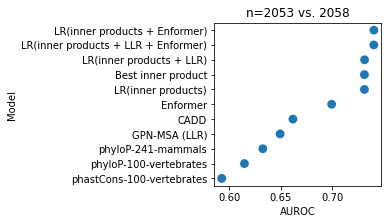

In [24]:
plt.figure(figsize=(3,3))
sns.pointplot(
    data=results.sort_values("AUROC", ascending=False).replace({
        "Enformer_l2": "Enformer",
        "GPN-MSA": "GPN-MSA (LLR)",
    }),
    y="Model",
    x="AUROC",
    join=False,
)
plt.title(subtitle);